In [1]:
from matplotlib import pyplot as plt
import random
import numpy as np
import tensorflow as tf
%matplotlib inline

## Pre-processed data

In [2]:
### Generate data additional data
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from scipy.ndimage.interpolation import shift
from helper_Functions import *
import tqdm
import time

#Augmentation will take a batch of training data, augmented 
#Input:  A list of images
#Return: A list of augmented images
def augmentation(images, labels):
    
    #X_Data, X_augmentation, y_Data, y_augmentation = train_test_split(images, labels, test_size=size, random_state=0)
    augmentedImgs = []
    augmentedLabes = [] 
    
    with tqdm.tqdm(total=(len(images))) as pbar:                        
        for idx, img in enumerate(images):
            #status bar
            pbar.update(1)

            #Randomly rescale angle between -20° and 20° (uniform)
            degreeR = random.randint(-20, 20)
            rotImage = rotate(img, degreeR, reshape=False)
            shifte = shift(rotImage, 2, order=3, mode="reflect", cval=0.5, prefilter=True)

            #Stretch factor between of 1.3 
            zm = clipped_zoom(shifte, 1.3)
            zm = zm.reshape(1, 32, 32, 3)

            #Randomly change Brightness
            zm = randomBrightness(zm)

            #store the augmented version
            images = np.concatenate((images, zm), axis=0)
            labels = np.append(labels, labels[idx])
            
    return images, labels

In [3]:
def pre_process_data():
    
    training_file = "traffic-signs-data/trainb.p"
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)

    X_Train, y_Train = train['features'], train['labels']

    #data before balance
    classes, counts = np.unique(y_Train, return_counts = True)
    print("Data before balance", counts)

    listItems = np.argwhere(y_Train == 0)
    indexList = []

    classes, counts = np.unique(y_Train, return_counts = True)
    for i in range (len(classes)):
        indexes = np.argwhere(y_Train == i)
        indexList.append(indexes[:min(counts)]) 

    ####craete the new list 
    deleteList = []
    for i in range (len(y_Train)):
        if(not(any(i in idx for idx in indexList))):
            deleteList.append(i)

    #Delete extra data
    y_Train = np.delete(y_Train, deleteList, None)
    X_Train = np.delete(X_Train, deleteList, 0)

    #Data after balance
    classes, counts = np.unique(y_Train, return_counts = True)
    print("Data After balance", counts)

    #Return: A list of augmented images
    X_Data, y_Data = augmentation(X_Train, y_Train)

    #Data after augmentation
    classes, counts = np.unique(y_Data, return_counts = True)
    print("Data After augmentation", counts)

    #Save Data pre-processed data
    dist_pickle = {}
    dist_pickle["X_Data"] = X_Data
    dist_pickle["y_Data"] = y_Data
    dist_pickle["X_Data"] = X_Data
    dist_pickle["y_Data"] = y_Data
    pickle.dump( dist_pickle, open( "traffic-signs-data/preProcData_pickle.p", "wb" ))

    return X_Data, y_Data

## Load The Data

In [4]:
 # Load pickled data
import os.path
import pickle

#Fill this in based on where you saved the training and testing data
testing_file = "traffic-signs-data/test.p"
valid_file = "traffic-signs-data/valid.p"

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(valid_file, mode='rb') as f:
    valid = pickle.load(f)


X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']


if not os.path.isfile("traffic-signs-data/preProcData_pickle.p"):
    # Load the camera calibration result 
    X_Data, y_Data = pre_process_data()
    
else: 
    # Load the camera calibration result 
    dist_pickle = pickle.load( open("traffic-signs-data/preProcData_pickle.p", "rb") )
    X_Data = dist_pickle["X_Data"]
    y_Data = dist_pickle["y_Data"]

# Split the data into Traing, Validation and Test 

In [5]:
#Shuffle training data
from sklearn.utils import shuffle

X_train, X_valid, y_train, y_valid = train_test_split(X_Data, y_Data, test_size=0.20, random_state=42)
#X_train, y_train = shuffle(X_Data, y_Data)

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

In [6]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = str(format(X_train[0].shape))
classes, counts = np.unique(y_Data, return_counts = True)
n_classes = len(classes)

print("Image Shape: {}".format(X_train[0].shape))
print("Number of training samples =", n_train)
print("Number of validation samples =", len(X_valid), (len(X_valid)*100)/n_train,"% of training data")
print("Number of testing samples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Image Shape: (32, 32, 3)
Number of training samples = 14448
Number of validation samples = 3612 25.0 % of training data
Number of testing samples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


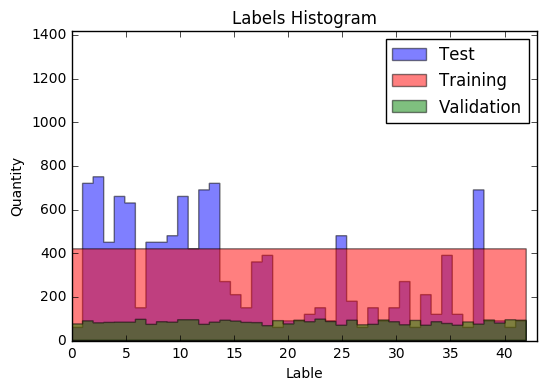

In [7]:
import matplotlib.pyplot as plt
from numpy.random import normal, uniform
bins = n_classes

plt.hist(y_test, bins=bins, histtype='stepfilled', color='b', alpha=.5, label='Test')
plt.hist(y_Data, bins=bins, histtype='stepfilled', color='r', alpha=.5, label='Training')
plt.hist(y_valid, bins=bins, histtype='stepfilled', color='g', alpha=.5, label='Validation')

plt.title("Labels Histogram")
plt.xlabel("Lable")
plt.ylabel("Quantity")
plt.axis([0, 43,  0, counts[0]+1000])

plt.legend()
plt.show()

# Visualize a sample image of the Dataset

36


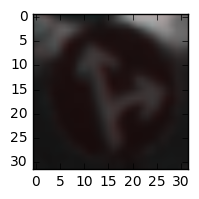

In [8]:
import numpy as np
import matplotlib.pyplot as plt

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(2,2))
plt.imshow(image)
print(y_train[index])

----

## Model Architecture

In [26]:
from tensorflow.contrib.layers import flatten

def conv2d(data, weight):
    return tf.nn.depthwise_conv2d_native(data,weight,strides=[1, 1, 1, 1],padding='VALID')    


def max_pool(data):
    return tf.nn.max_pool(data, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def LeNet(x):    
    # Arguments for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    dropout = .4
    
    #rgb_to_grayscale
    x = tf.image.rgb_to_grayscale(x, name='grayscale')
    
    x = tf.nn.l2_normalize(x, 1, epsilon=1e-12, name=None)
    #Layer 1: Convolutional. Input = 32x32x1. Output = 26x26x6.
    #out_height = ceil(float(32 - 7 + 1) / float(1)) = 26
    conv1_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.bias_add(conv2d(x, conv1_W), conv1_b)
    conv1 = tf.nn.elu(conv1)   # Activation.
    #Pooling. Input = 26x26x5. Output = 13x13x5 out_height = ceil(float(28 - 2 + 1) / float(2)) =  ceil(13.5) = 13
    conv1 = max_pool(conv1)
    conv1  = tf.nn.elu(conv1)   # Activation.
    print (conv1)
    
    x = tf.nn.l2_normalize(x, 1, epsilon=1e-12, name=None)
    # Layer 2: Convolutional. 1Input = 13, 13, 8 Output = 11, 11, 16.
    #out_height = ceil(float(13 - 3 + 1) / float(1)) = 11
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 2), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2  = conv2d(conv1, conv2_W)+conv2_b
    conv2  = tf.nn.elu(conv2)   # Activation.
    print (conv2)
    
    x = tf.nn.l2_normalize(x, 1, epsilon=1e-12, name=None)
    #Layer 2: Convolutional. 1Input = 11, 11, 30 Output = 8, 8, 35.
    #out_height = ceil(float(8 - 4 + 1) / float(1)) = 8
    conv3_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 32, 2), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3  = conv2d(conv2, conv3_W)+conv3_b
    conv3  = tf.nn.elu(conv3)   # Activation.
    conv3  = max_pool(conv3)    #Pooling. Input = 8, 8, 64. Output = 4, 4, 64.
    conv3  = tf.nn.elu(conv3)   # Activation.
    print (conv3)

    #Flatten. Input = 4, 4, 64. Output = 1024.
    fc0    = flatten(conv3) 
    #Layer 3: Fully Connected. Input = 1024. Output = 688.
    fc1_W  = tf.Variable(tf.truncated_normal(shape=(1024, 688), mean = mu, stddev = sigma))
    fc1_b  = tf.Variable(tf.zeros(688))
    fc1    = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.elu(fc1)  # Activation.
    fc1    = tf.nn.dropout(fc1, dropout)

    #Layer 4: Fully Connected. Input = 688. Output = 172.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(688, 172), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(172))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.elu(fc2)  # Activation.
    fc2    = tf.nn.dropout(fc2, dropout)

    #Layer 5: Fully Connected. Input = 172. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(172, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    
    weights = fc3_W
    bias    = fc3_b
    
    logits = tf.matmul(fc2, weights) + bias
    
    return logits

# Features and Labels

In [27]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

weights = tf.Variable(tf.zeros([1, 1], dtype=tf.float32))
bias = tf.Variable(tf.ones([1, 1], dtype=tf.float32))

one_hot_y = tf.one_hot(y, 43)

# Training Pipeline

In [28]:
rate = 0.001
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Tensor("Elu_15:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("Elu_16:0", shape=(?, 11, 11, 32), dtype=float32)
Tensor("Elu_18:0", shape=(?, 4, 4, 64), dtype=float32)


# Evaluate model against validation data set

In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train the Model

In [30]:
import time
last_accuracy = 0
EPOCHS = 50
'''NOTE: If batch size is too small, the training accuracy 
will be less meaningful with a much smaller sample size.'''
BATCH_SIZE = 128   #++BATCH_SIZE ++Fater it Stops Growing

save_file = 'model.ckpt'
saver = tf.train.Saver()

beginTime = time.time()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        #Stop Training 
        if (last_accuracy > (validation_accuracy + .002)):
            break
        else: 
            last_accuracy = validation_accuracy
        
    saver.save(sess, save_file)
    print("Model saved")
    
endTime = time.time()
print('Total time: {:5.2f}s'.format(endTime - beginTime))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.512

EPOCH 2 ...
Validation Accuracy = 0.725

EPOCH 3 ...
Validation Accuracy = 0.810

EPOCH 4 ...
Validation Accuracy = 0.839

EPOCH 5 ...
Validation Accuracy = 0.864

EPOCH 6 ...
Validation Accuracy = 0.886

EPOCH 7 ...
Validation Accuracy = 0.886

EPOCH 8 ...
Validation Accuracy = 0.908

EPOCH 9 ...
Validation Accuracy = 0.916

EPOCH 10 ...
Validation Accuracy = 0.915

EPOCH 11 ...
Validation Accuracy = 0.918

EPOCH 12 ...
Validation Accuracy = 0.930

EPOCH 13 ...
Validation Accuracy = 0.930

EPOCH 14 ...
Validation Accuracy = 0.934

EPOCH 15 ...
Validation Accuracy = 0.935

EPOCH 16 ...
Validation Accuracy = 0.936

EPOCH 17 ...
Validation Accuracy = 0.935

EPOCH 18 ...
Validation Accuracy = 0.941

EPOCH 19 ...
Validation Accuracy = 0.940

EPOCH 20 ...
Validation Accuracy = 0.942

EPOCH 21 ...
Validation Accuracy = 0.945

EPOCH 22 ...
Validation Accuracy = 0.946

# Evaluate model against test data set

In [31]:
import tensorflow as tf
save_file = './model.ckpt'

with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.814


# Predict other traffic signs

Tensor("Elu_92:0", shape=(?, 13, 13, 16), dtype=float32)
Tensor("Elu_93:0", shape=(?, 11, 11, 32), dtype=float32)
Tensor("Elu_95:0", shape=(?, 4, 4, 64), dtype=float32)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
     Preditcion Image = [32]       Web Image  = [29]


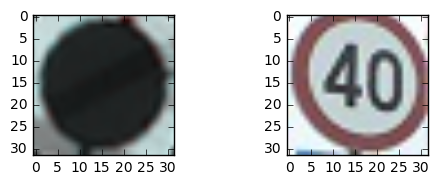

     Preditcion Image = [41]       Web Image  = [20]


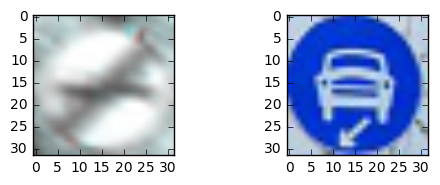

     Preditcion Image = [14]       Web Image  = [34]


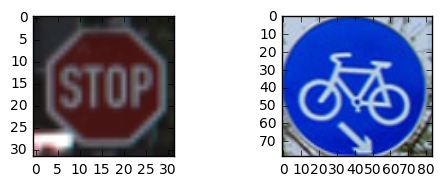

     Preditcion Image = [27]       Web Image  = [25]


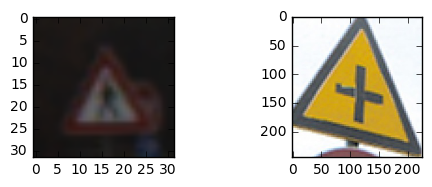

     Preditcion Image = [14]       Web Image  = [34]


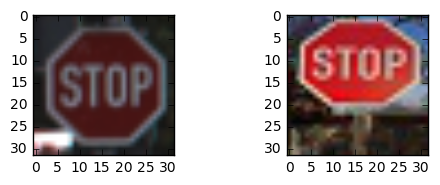

     Preditcion Image = [2]       Web Image  = [42]


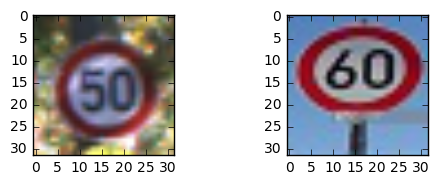

In [42]:
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib inline
fig = []

#import images
images = []
for img in glob.glob("traffic-signs-data/*.jpg"):
    images.append(mpimg.imread(img))

    
# Predictions
x = tf.placeholder(tf.float32, (None, 32, 32,3))
logits = LeNet(x)
pred = tf.argmax(logits , 1)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, save_file)

    for i in range (0,len(images)):
        resized_image = tf.image.resize_images(images[i], [32, 32])
        result = sess.run(resized_image)
        reshaped_image=result.reshape(( 1,32,32,3))
        preditcion = sess.run(pred, feed_dict={x: reshaped_image})

        #print images
        fig=plt.figure()
        data=np.arange(900).reshape((30,30))
        ax=fig.add_subplot(2,2,2)        
        ax.imshow(images[i])
        ax=fig.add_subplot(2,2,1) 
        
        for ind in range (len(y_train)):
            if (int(preditcion) == y_train[ind]):
                ax.imshow(X_train[ind])
                break
                        
        print("     Preditcion Image = {}       Web Image  =".format(preditcion), y_train[preditcion]) 
        plt.show()